# Time Series Forecasting Using SARIMA
## Introduction
In this project, I performed a time series forecasting analysis using the Air Passenger dataset, which contains monthly airline passenger counts from 1949 to 1960. The primary goal was to forecast future passenger numbers using historical data and time series modelling techniques. This project demonstrates how to effectively apply the Seasonal AutoRegressive Integrated Moving Average (SARIMA) model to capture both seasonal and non-seasonal patterns in the data. I also compared SARIMA to a simpler ARIMA model to illustrate the significance of accounting for seasonality in time series data.

## Data Overview and Preprocessing
The dataset contains two columns:
- Month: Time period ranging from January 1949 to December 1960
- Passengers: Number of passengers per month

Upon loading the data, I made the following observations:
- The dataset contained 144 entries (monthly data points).
- The "Month" column was initially a string, so I converted it to a datetime object for time series analysis.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import itertools
from statsmodels.tools.eval_measures import aic, bic
import scipy.stats as stats
from statsmodels.stats.stattools import durbin_watson

In [2]:
airdata = pd.read_csv("AirPassengers.csv")
airdata.info()
airdata['Month'] = pd.to_datetime(airdata['Month'], format="%Y-%m")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Month        144 non-null    object
 1   #Passengers  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


To proceed with time series analysis, I set the "Month" column as the index and specified the frequency as monthly ('MS'). The data was divided into a training set (80%) and a testing set (20%) to evaluate the forecasting performance.

In [3]:
airdata.set_index('Month', inplace=True)
airdata = airdata.asfreq('MS')

# Split the data into train and test sets
train_size = int(len(airdata) * 0.8)
train, test = airdata.iloc[:train_size], airdata.iloc[train_size:]

To understand the underlying patterns, I plotted the number of passengers over time. This revealed a clear upward trend and yearly seasonality.

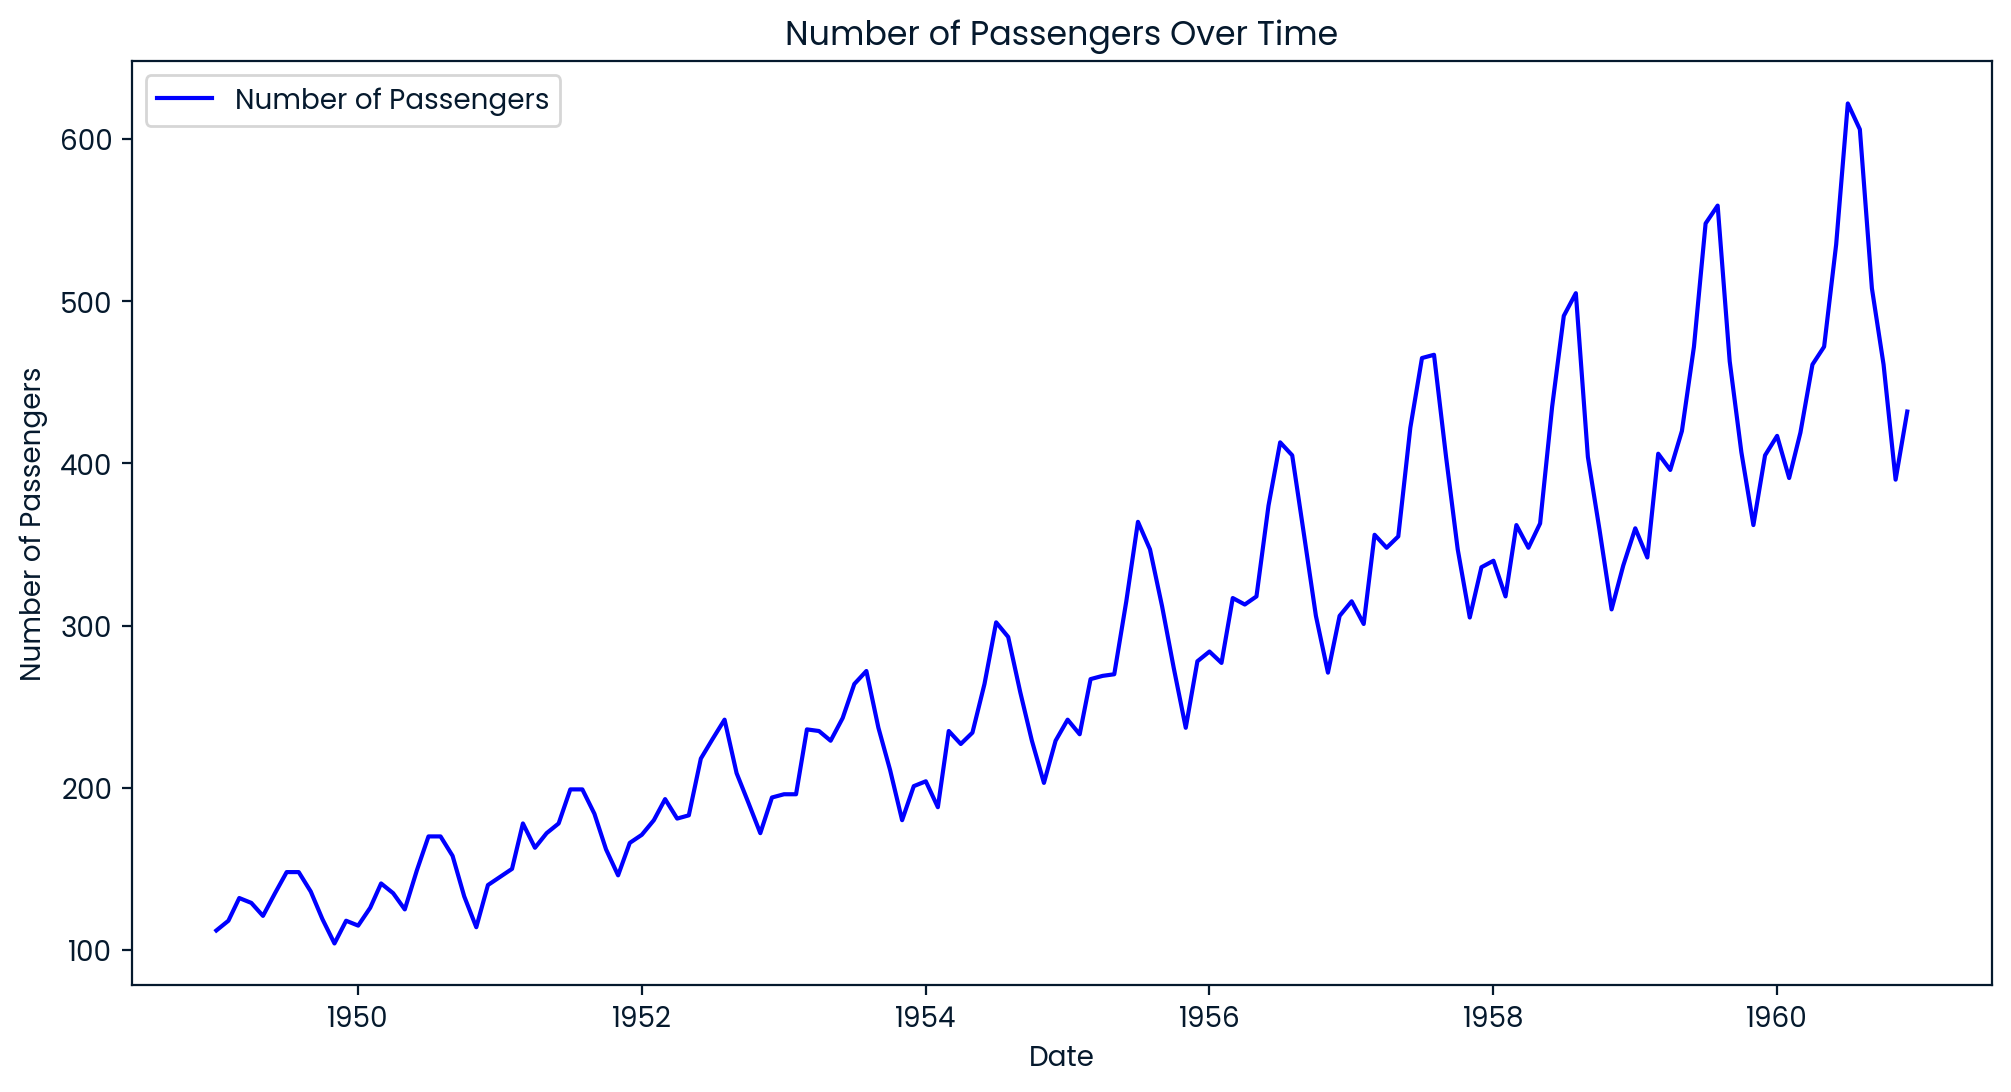

In [4]:
# Plot the number of passengers over time
plt.figure(figsize=(12, 6))
plt.plot(airdata.index, airdata['#Passengers'], label='Number of Passengers', color='blue')
plt.xlabel('Date')
plt.ylabel('Number of Passengers')
plt.title('Number of Passengers Over Time')
plt.legend()
plt.show()

## Seasonal Decomposition
Before model selection, I decomposed the time series into its trend, seasonal, and residual components to better understand the data.

- The trend component shows an overall increasing number of passengers over time.
- The seasonal component repeats yearly, showing peaks and troughs at consistent times every year, indicating strong seasonality.
- The residual component represents random noise after removing the trend and seasonality.

The clear trend and seasonal patterns suggested that a SARIMA model, capable of handling both trends and seasonality, would be suitable for forecasting.

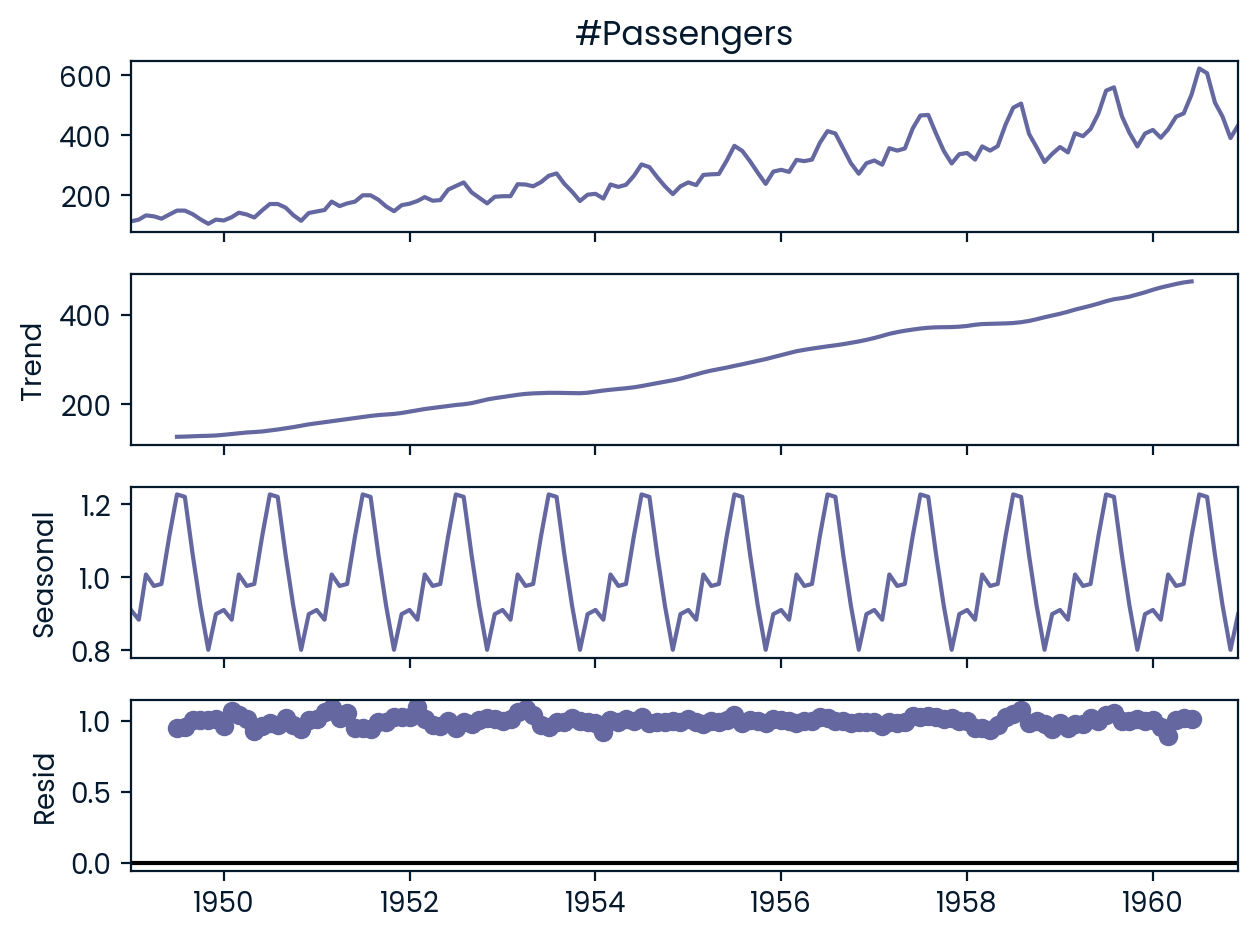

In [5]:
decomposition = seasonal_decompose(airdata['#Passengers'], model='multiplicative')
decomposition.plot()
plt.show()

## Stationarity Check and Differencing
To perform accurate time series modelling, the data must be stationary — meaning it has a constant mean and variance over time. Stationary data ensures that model parameters remain consistent across time, improving forecast accuracy.

I applied the Augmented Dickey-Fuller (ADF) test to check for stationarity. The initial ADF test returned a p-value of 0.99, indicating that the data is not stationary. To address this, I applied differencing to the data, then repeated the ADF test on the differenced data.

In [6]:
# Perform the ADF test on '#Passengers'
adf_test = adfuller(airdata['#Passengers'])
print(f'ADF Statistic: {adf_test[0]}')
print(f'p-value: {adf_test[1]}')

ADF Statistic: 0.8153688792060498
p-value: 0.991880243437641


In [7]:
# Apply differencing to make the data stationary
airdata['Differenced'] = airdata['#Passengers'].diff()

# Re-run ADF test on the differenced data
adf_test_diff = adfuller(airdata['Differenced'].dropna())
print(f'ADF Statistic after differencing: {adf_test_diff[0]}')
print(f'p-value after differencing: {adf_test_diff[1]}')

ADF Statistic after differencing: -2.8292668241700047
p-value after differencing: 0.05421329028382478


After applying first-order differencing, the ADF test gave a p-value of 0.0542, still slightly above the typical threshold of 0.05 for stationarity. A second differencing yielded a p-value < 0.01, achieving stationarity.

ADF Statistic after 2nd differencing: -16.384231542468513
p-value after 2nd differencing: 2.7328918500142026e-29


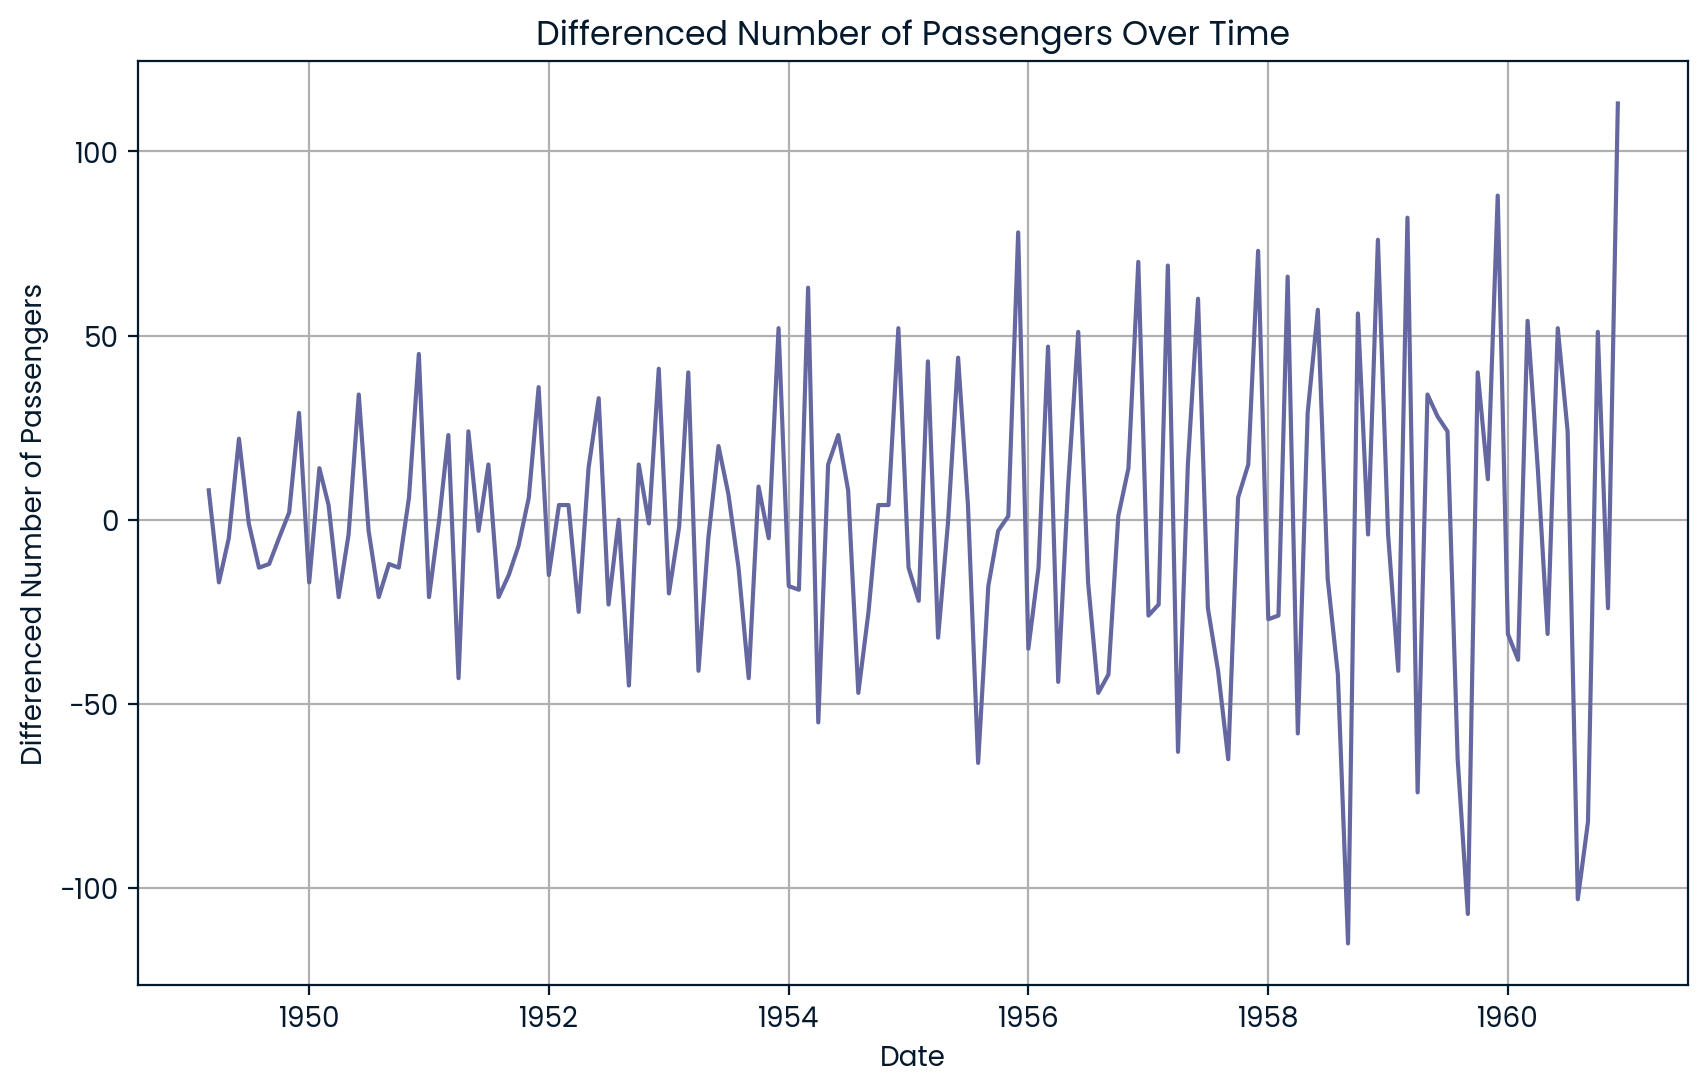

In [8]:
# Apply differencing again
airdata['Differenced'] = airdata['Differenced'].diff()

# Re-run ADF test on the differenced data
adf_test_diff2 = adfuller(airdata['Differenced'].dropna())
print(f'ADF Statistic after 2nd differencing: {adf_test_diff2[0]}')
print(f'p-value after 2nd differencing: {adf_test_diff2[1]}')

# Plot the differenced data
plt.figure(figsize=(10, 6))
plt.plot(airdata.index, airdata['Differenced'])
plt.title('Differenced Number of Passengers Over Time')
plt.xlabel('Date')
plt.ylabel('Differenced Number of Passengers')
plt.grid(True)
plt.show()

## Model Selection: SARIMA
SARIMA extends the ARIMA model by incorporating seasonal components, making it more suitable for time series with repeating seasonal patterns.

### ACF and PACF Analysis
I plotted the Auto-Correlation Function (ACF) and Partial Auto-Correlation Function (PACF) to identify potential parameters for the autoregressive (AR) and moving average (MA) terms. The PACF suggested a significant lag at 3.

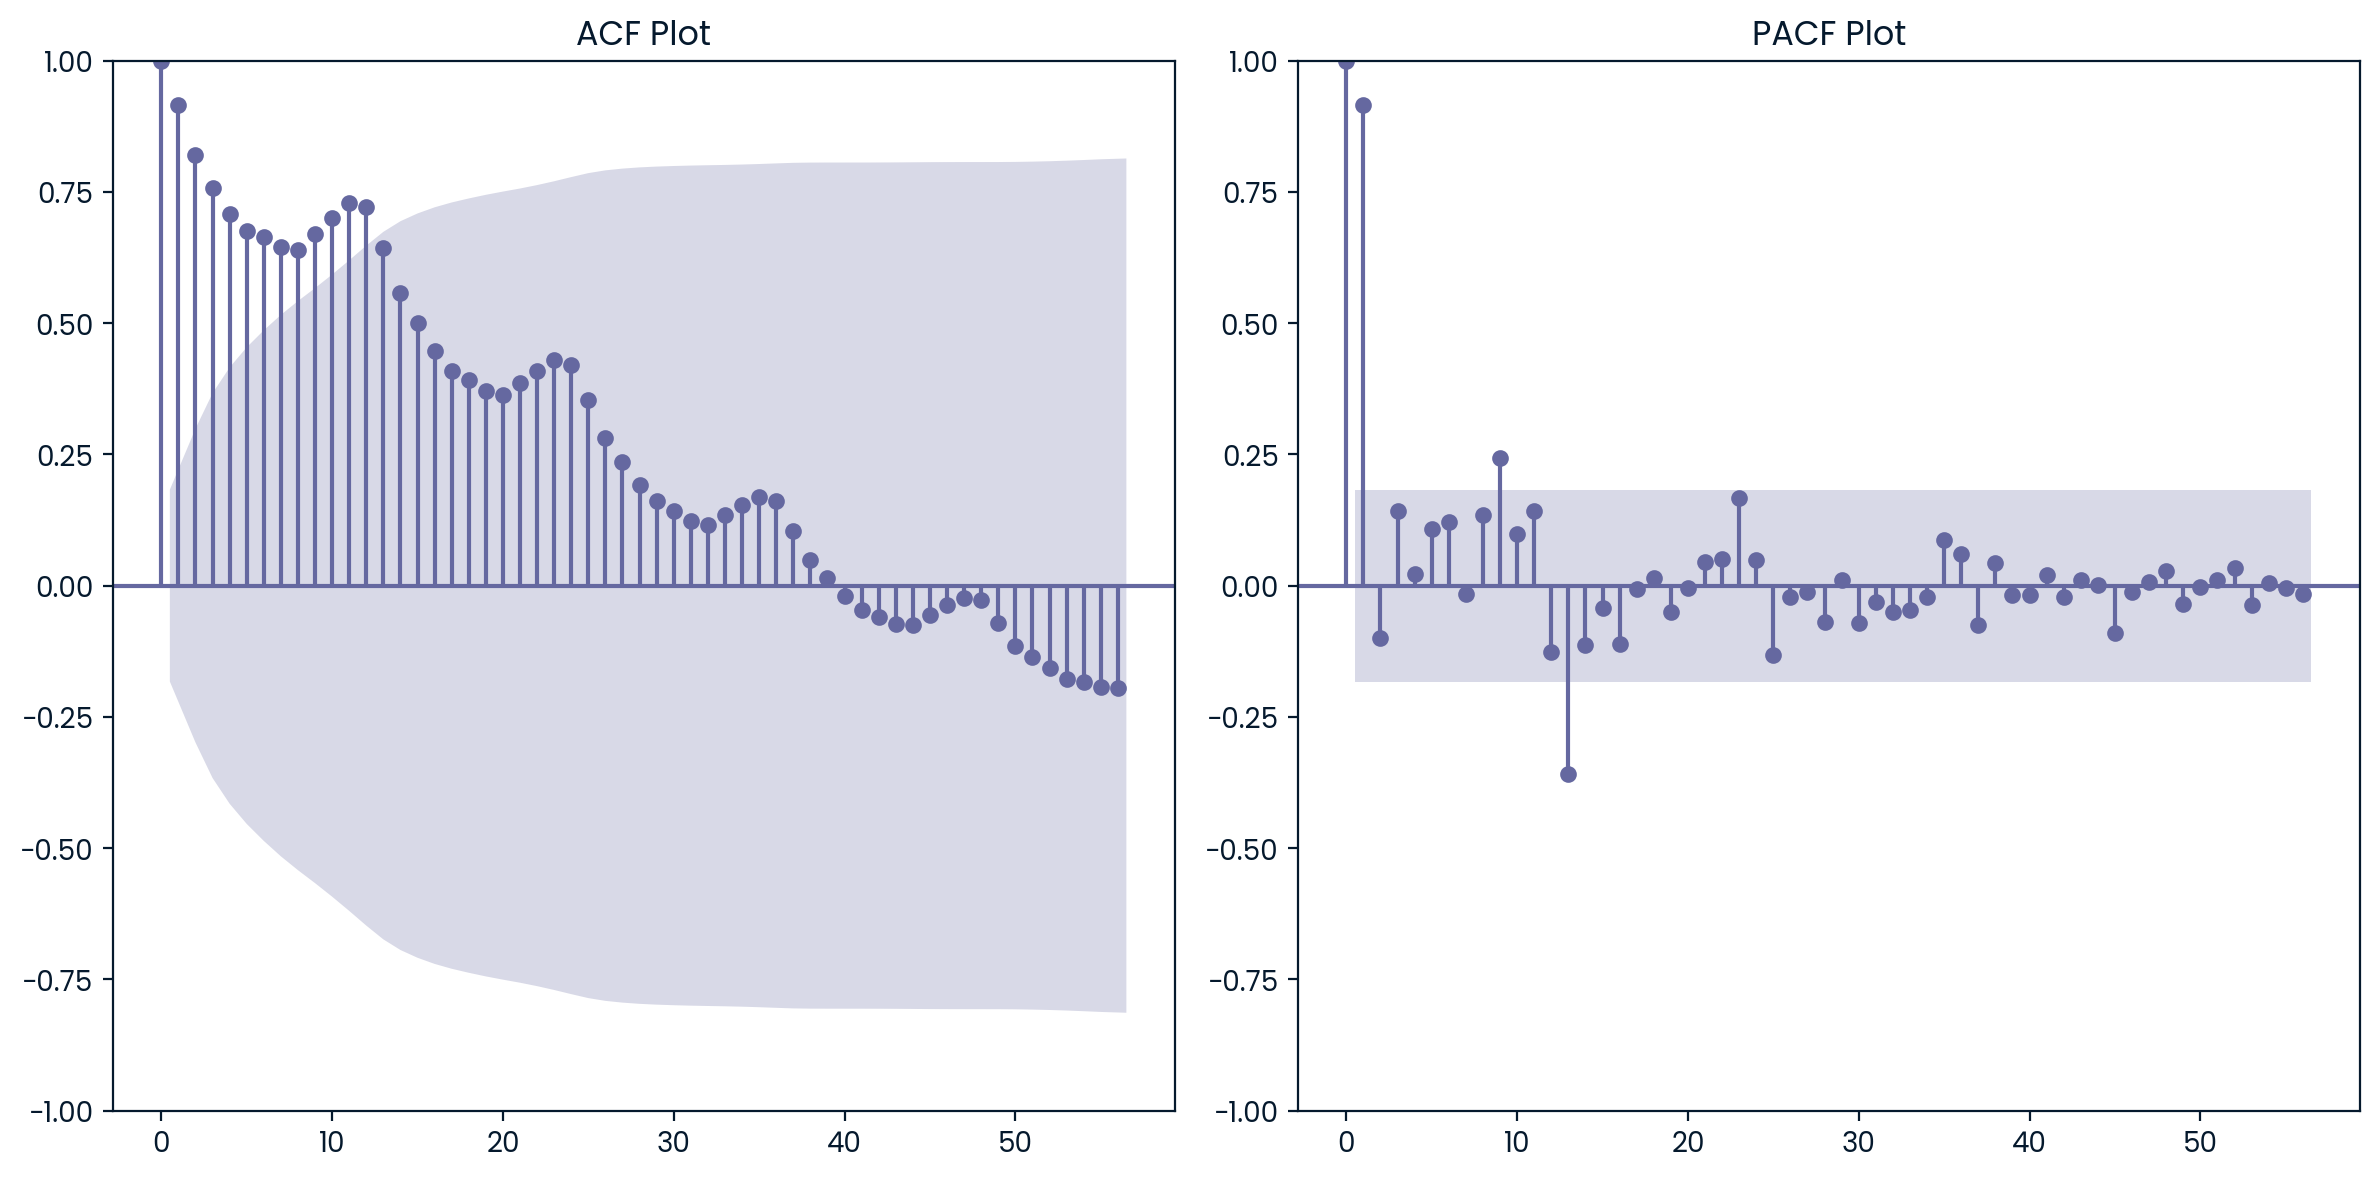

In [6]:
# Plot ACF and PACF
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plot_acf(train, lags=56, ax=plt.gca())
plt.title('ACF Plot')

plt.subplot(1, 2, 2)
plot_pacf(train, lags=56, ax=plt.gca())
plt.title('PACF Plot')

plt.tight_layout()
plt.show()

### Grid Search for Optimal Parameters
To find the best combination of parameters for the SARIMA model, I conducted a grid search, exploring various values for the non-seasonal parameters (p, d, q) and seasonal parameters (P, D, Q). Based on the PACF plot and the number of required differencing steps, I set p = 3 and d = 2. The optimal parameters were selected by minimising both the Akaike Information Criterion (AIC) and Bayesian Information Criterion (BIC). The best model had an AIC of 752.45 and a BIC of 773.37, with non-seasonal parameters (3, 2, 4) and seasonal parameters (0, 1, 0).

In [12]:
# Define parameter grid
p = 3
d = 2
q_values = range(0, 5)
P_values = range(0, 2)
D_values = [0, 1]
Q_values = range(0, 2)
m = 12  # Seasonal period for yearly seasonality

best_aic = np.inf
best_bic = np.inf
best_params = None
best_model = None

# Grid search
for q in q_values:
    for P, D, Q in itertools.product(P_values, D_values, Q_values):
        try:
            # Fit SARIMA model
            model = SARIMAX(train, order=(p, d, q), seasonal_order=(P, D, Q, m))
            results = model.fit(disp=False, maxiter=1000)
            
            # Calculate AIC and BIC
            current_aic = results.aic
            current_bic = results.bic
            
            # Compare with best values
            if current_aic < best_aic:
                best_aic = current_aic
                best_bic = current_bic
                best_params = (p, d, q, P, D, Q)
                best_model = results

            if current_bic < best_bic:
                best_bic = current_bic
                best_params = (p, d, q, P, D, Q)
                best_model = results
                
        except Exception as e:
            print(f"Error fitting SARIMA model with parameters (p={p}, d={d}, q={q}, P={P}, D={D}, Q={Q}): {e}")

In [13]:
print(f"Best AIC: {best_aic} with parameters {best_params}")
print(f"Best BIC: {best_bic} with parameters {best_params}")

Best AIC: 752.4452942525036 with parameters (3, 2, 4, 0, 1, 0)
Best BIC: 773.3662583872336 with parameters (3, 2, 4, 0, 1, 0)


## Model Diagnostics
### Model Summary
After fitting the SARIMA model, I checked the summary to interpret the coefficients and diagnostic statistics. The Ljung-Box test indicated no significant autocorrelation in residuals, meaning the model fits the data well.

In [7]:
# Define the SARIMA model with chosen parameters
sarima_model = SARIMAX(train, order=(3, 2, 4), seasonal_order=(0, 1, 0, 12))

# Fit the SARIMA model
sarima_fit = sarima_model.fit(disp=False, maxiter=1000)

# Summary of the model
print(sarima_fit.summary())

                                      SARIMAX Results                                      
Dep. Variable:                         #Passengers   No. Observations:                  115
Model:             SARIMAX(3, 2, 4)x(0, 1, [], 12)   Log Likelihood                -368.223
Date:                             Mon, 16 Sep 2024   AIC                            752.445
Time:                                     15:15:12   BIC                            773.366
Sample:                                 01-01-1949   HQIC                           760.915
                                      - 07-01-1958                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0179      0.146     -6.980      0.000      -1.304      -0.732
ar.L2          0.7282      

### Residual Analysis
To ensure a good model fit, I examined the residuals. Ideally, residuals should have no pattern, indicating that the model has effectively captured the underlying structure of the data.

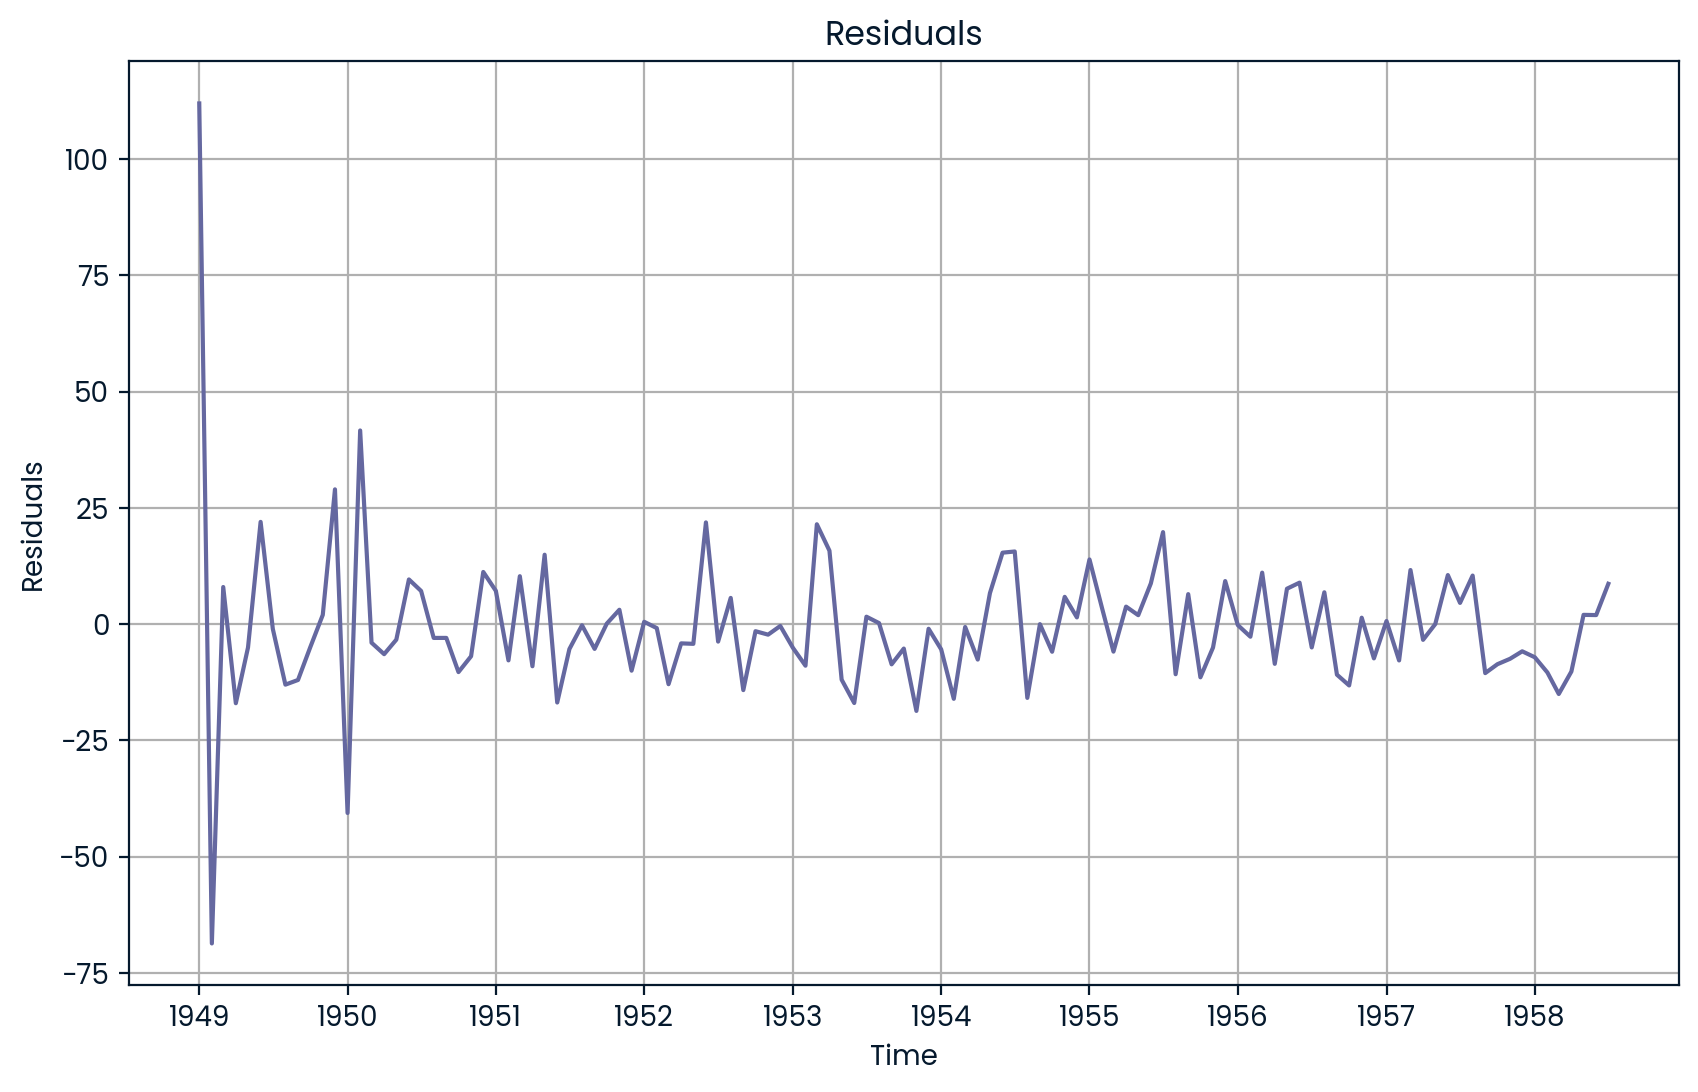

In [8]:
# Plot residuals
residuals = sarima_fit.resid
plt.figure(figsize=(10, 6))
plt.plot(residuals)
plt.title('Residuals')
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.grid(True)
plt.show()

### Durbin-Watson Test
The Durbin-Watson statistic checks for autocorrelation in residuals. A value near 2 suggests no significant autocorrelation.

In [9]:
dw = durbin_watson(residuals)
print(f'Durbin-Watson statistic: {dw}')

Durbin-Watson statistic: 2.306083627459275


### QQ Plot
A QQ plot was used to check if the residuals follow a normal distribution.

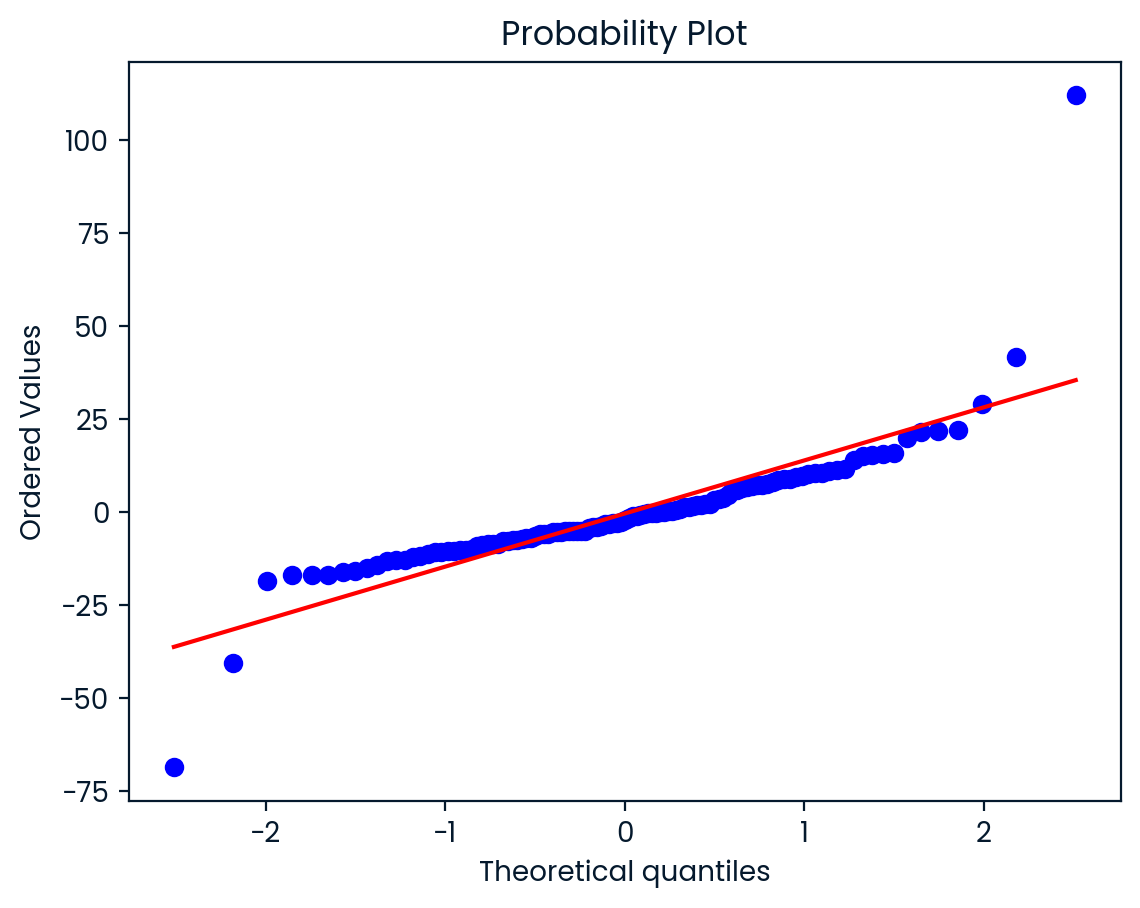

In [10]:
stats.probplot(residuals, dist="norm", plot=plt)
plt.show()

## Forecasting and Evaluation
### Forecasting with SARIMA
I used the fitted SARIMA model to forecast the number of passengers in the test dataset. The mean squared error (MSE) between the actual and forecasted values was 527.07, which indicates a reasonably good fit, considering the dataset's variability.

In [11]:
# Make predictions
forecast = sarima_fit.forecast(steps=len(test))
sarima_mse = mean_squared_error(test, forecast)
print(f'SARIMA Model MSE: {sarima_mse:.2f}')

SARIMA Model MSE: 527.07


### ARIMA for Comparison
To highlight the significance of seasonality, I fitted a non-seasonal ARIMA model and compared its performance. The ARIMA Model MSE was 21,149.49, which is significantly worse than the SARIMA model, confirming the importance of accounting for seasonality.

In [15]:
# ARIMA model for comparison
arima_model = ARIMA(train, order=(3, 2, 4))
arima_fit = arima_model.fit()
forecast_arima = arima_fit.forecast(steps=len(test))
arima_mse = mean_squared_error(test, forecast_arima)
print(f'ARIMA Model MSE: {arima_mse:.2f}')

ARIMA Model MSE: 21149.49


### Forecast Plot
I plotted the actual vs. forecasted values for both models to visually compare their performances.

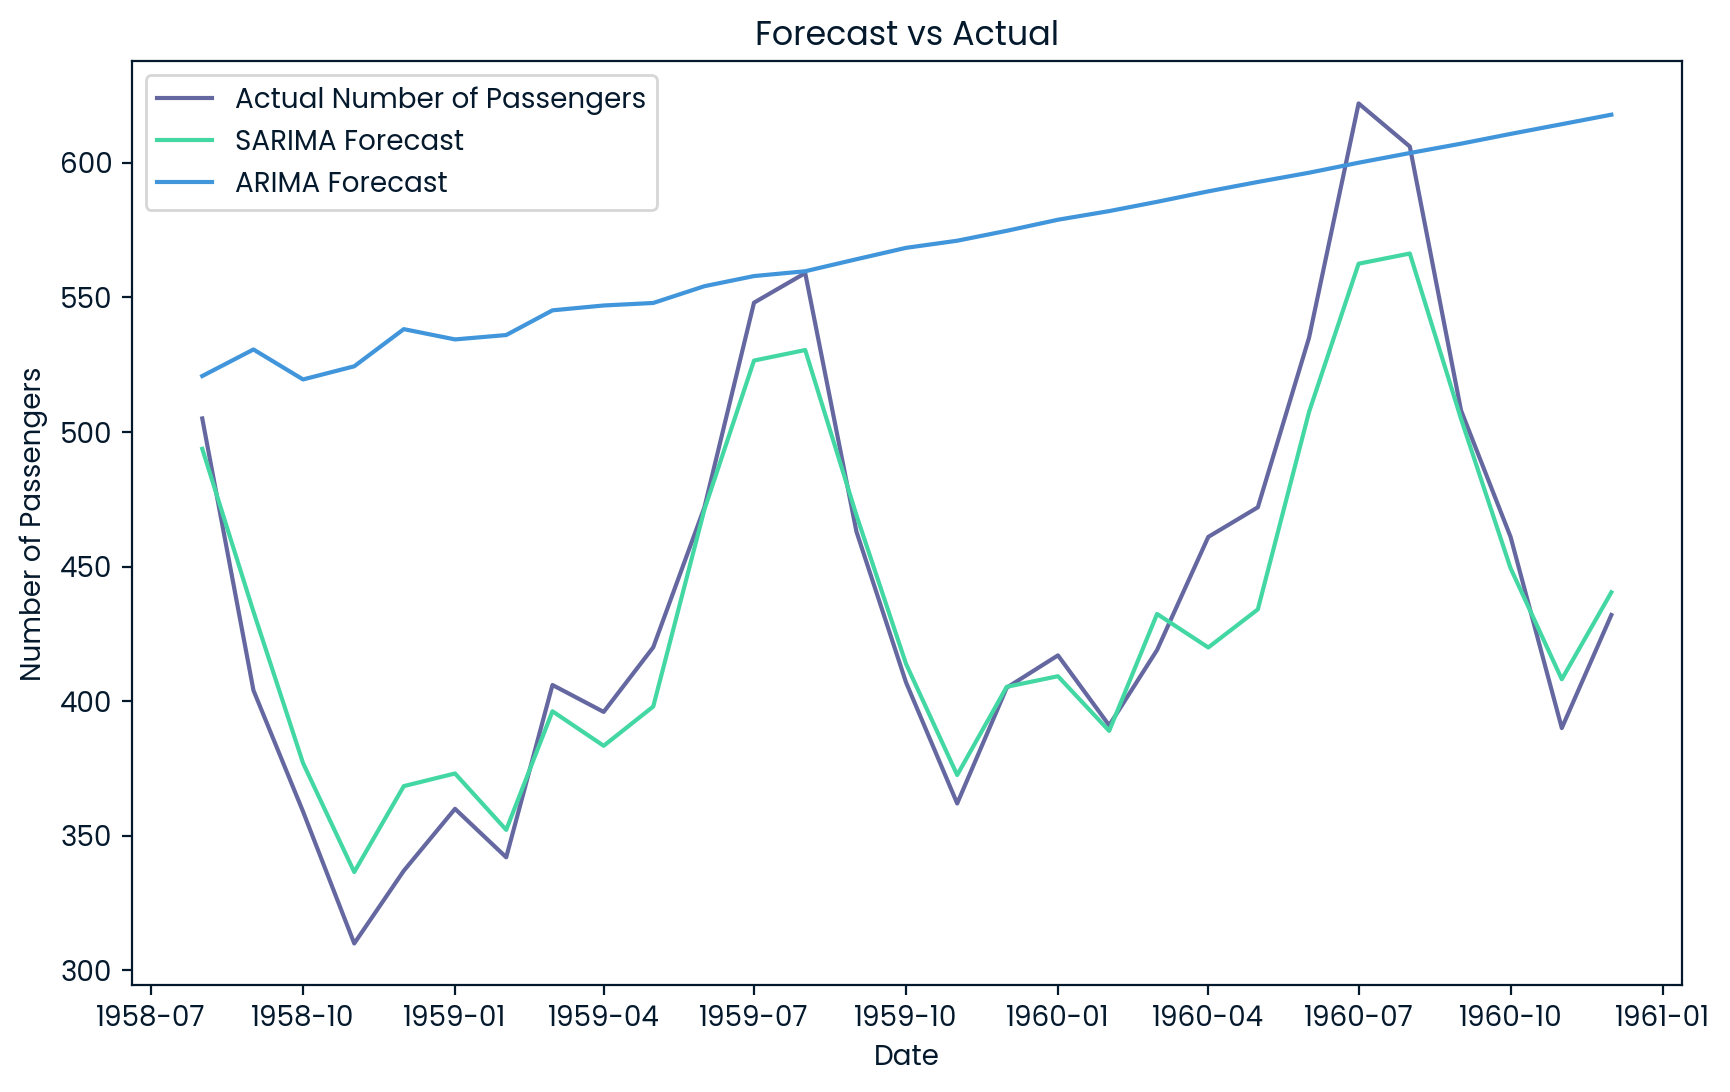

In [16]:
# Plot forecast vs actual values
plt.figure(figsize=(10,6))
plt.plot(test, label='Actual Number of Passengers')
plt.plot(forecast.index, forecast, label='SARIMA Forecast')
plt.plot(forecast_arima.index, forecast_arima, label='ARIMA Forecast')
plt.title("Forecast vs Actual")
plt.xlabel('Date')
plt.ylabel('Number of Passengers')
plt.legend()
plt.show()

## Conclusion
This project demonstrates the effective application of time series forecasting using the SARIMA model to predict air passenger numbers. Through thorough data exploration, I identified a clear upward trend and annual seasonality in the data, making SARIMA a suitable model. Key steps in the process included transforming the data to achieve stationarity, conducting seasonal decomposition to understand the underlying components, and performing a grid search to find the optimal model parameters.

The selected SARIMA model provided reasonably accurate predictions, with a mean squared error (MSE) of 519.69, highlighting its capability to capture both trend and seasonality. A comparison with a non-seasonal ARIMA model showed the superiority of SARIMA in handling the seasonal nature of the data, as the ARIMA model had a much higher MSE of 21,149.49.

This project underscores the importance of proper data preprocessing, parameter tuning, and diagnostic checks in time series forecasting. Whilst the SARIMA model performed well, further improvements could include integrating exogenous variables or exploring advanced models like Prophet or LSTM to enhance forecast accuracy.